In [16]:
'''
Binary Classification using Convolutional Auto-Encoder
@author bh.hwang@iae.re.kr
'''

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from tqdm import tqdm

# Load Training Dataset
trainset = pd.read_csv("./dataset/severstal-steel-defect/train.csv")
trainset_path = Path("./dataset/severstal-steel-defect/train_images")
print(f"Trainset Shape : {trainset.shape}")

image_files = [filename for filename in os.listdir(trainset_path) if filename.endswith(".jpg")]
list_imgs = []
for each in image_files:
    for i in range (4):
        list_imgs.append(each)
        
list_type = []
for i in range (int(len(list_imgs)/4)):
    for j in range (4):
        list_type.append(j+1)
        
train_df_2 = pd.DataFrame()
train_df_2['ImageId'] = list_imgs
train_df_2['ClassId'] = list_type
train_df_2.head()

train_df_2['EncodedPixels'] = [np.nan] * len(list_type)
train_df_2['has_mask'] = [False] * len(list_type)

train_df_2.tail()

for i in tqdm(range(trainset.shape[0])):
    train_df_2.loc[(train_df_2.ImageId == trainset.ImageId[i]) & (train_df_2.ClassId == trainset.ClassId[i]), 'EncodedPixels'] = trainset.loc[(trainset.ImageId == trainset.ImageId[i]) & (trainset.ClassId == trainset.ClassId[i]),'EncodedPixels'].values
    train_df_2.loc[(train_df_2.ImageId == trainset.ImageId[i]) & (train_df_2.ClassId == trainset.ClassId[i]), 'has_mask'] = True





Trainset Shape : (7095, 3)


  0%|          | 0/7095 [00:00<?, ?it/s]/var/folders/8t/zc1f17h93tl7lhmp92437l9m0000gn/T/ipykernel_52956/514000446.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 9

In [18]:
mask_count = pd.DataFrame()
array1 = train_df_2.ImageId.unique()
array2 = [0] * len(array1)
mask_count['ImageId'] = array1
mask_count['has_mask'] = array2
mask_count.head()

array_judge = trainset.ImageId
for each in array_judge:
    if each:
         mask_count.loc[mask_count['ImageId'] == each,"has_mask"] += 1
         
mask_count.loc[mask_count.has_mask==3,:]

,ImageId,has_mask
4612,db4867ee8.jpg,3
6079,ef24da2ba.jpg,3


In [ ]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_loss(y_true, y_pred):
#     smooth = 1.
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return 1. - score
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

train_df = train_df_2.copy()

sample_filename = '0002cc93b.jpg'
sample_image_df = trainset[trainset['ImageId'] == sample_filename]
sample_path = f"../input/severstal-steel-defect-detection/train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

In [ ]:

positive_dataframe = train_dataframe.loc[train_dataframe.ClassId==3]
negative_dataframe = train_dataframe.loc[train_dataframe.ClassId==2]

print(f"Positive sample size : {positive_dataframe.shape[0]}") #as normal
print(f"Negative sample size : {negative_dataframe.shape[0]}") #as abnormal

#defect image decoding
train_df = train_df_2.copy()

sample_filename = '0002cc93b.jpg'
sample_image_df = train_df[train_df['ImageId'] == sample_filename]
sample_path = f"../input/severstal-steel-defect-detection/train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

# original image(1600x256) expand by spliting into 256x256
overlap_ratio = 0.5
original_w = 1600
original_h = 256

positive_dataframe_ex = pd.DataFrame(columns=['ImageId', 'ClassId', 'EncodedPixels', 'hasDefect'])
n_split = int((original_w-original_h)/(original_h*overlap_ratio))+1
split_w_index = [original_h*overlap_ratio*i for i in range(n_split)]


for n in tqdm(range(positive_dataframe.shape[0])):
    for i in split_w_index:
        # check
        row = [positive_dataframe.iloc[[n]].ImageId.item(), positive_dataframe.iloc[[n]].ClassId.item(), positive_dataframe.iloc[[n]].EncodedPixels.item(), False]
        positive_dataframe_ex.loc[len(positive_dataframe_ex)] = row

In [101]:
'''
Convolutional Autoencoder Model
'''
import torch

args = {
	'BATCH_SIZE': 5,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 20
    }

class ConvolutionalAE(torch.nn.Module):
    def __init__(self):
        super(ConvolutionalAE, self).__init__()
        
        # Encoder
        self.cnn_layer1 = torch.nn.Sequential(
                        torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(2,2))

        self.cnn_layer2 = torch.nn.Sequential(
                                torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                torch.nn.ReLU(),
                                torch.nn.MaxPool2d(2,2))

        # Decoder
        self.tran_cnn_layer1 = torch.nn.Sequential(
                        torch.nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                        torch.nn.ReLU())

        self.tran_cnn_layer2 = torch.nn.Sequential(
                        torch.nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                        torch.nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)

        return output
    
    
model = ConvolutionalAE()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])

# model training
steps = 0
total_steps = len(train_loader)
for epoch in range(args['NUM_EPOCH']):
    running_loss = 0
    for i, (X_train, _) in enumerate(train_loader):
        steps += 1

        outputs = model(X_train)
        loss = criterion(outputs, X_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()*X_train.shape[0]
        
        if steps % total_steps == 0:
            model.eval()
            print('Epoch: {}/{}'.format(epoch+1, args['NUM_EPOCH']),
                 'Training loss: {:.5f}..'.format(running_loss/total_steps))
            
            steps = 0
            running_loss = 0
            model.train()

KeyError: "None of [Index([0], dtype='int64')] are in the [columns]"

          ImageId  ClassId                                      EncodedPixels
1   0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
4   0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...
5   0025bde0c.jpg        3  8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
11  0046839bd.jpg        3  152926 1 153180 4 153434 6 153689 8 153943 11 ...
12  005d86c25.jpg        3  331 18 587 53 843 89 1099 124 1355 159 1611 17...
Class 3 sample : (5150, 3)
Class 1 sample : (897, 3)
<class 'str'>


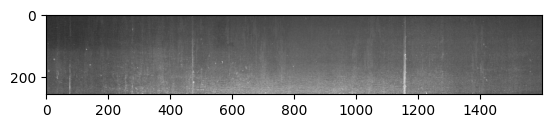

In [54]:
# sample
class3_sample = train_df.loc[train_df.ClassId==3]
class1_sample = train_df.loc[train_df.ClassId==1]
print(class3_sample.head())

print(f"Class 3 sample : {class3_sample.shape}")
print(f"Class 1 sample : {class1_sample.shape}")

path = train_path_root / str(class3_sample.iloc[[0]].ImageId.item())
print(type(str(path.absolute())))
image = cv2.imread(str(path.absolute()))

plt.imshow(image)


